# Обучение GNN-модели на датасете графов

In [11]:
%load_ext autoreload
%autoreload 2

import os
from src.data.hydrodataset import HydroDataset

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnprocessor import GNNProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [13]:
dataset = HydroDataset(root="/tmp/hydro")
train_ds = dataset[20:]
print("Dataset length:", len(train_ds))

Dataset length: 60


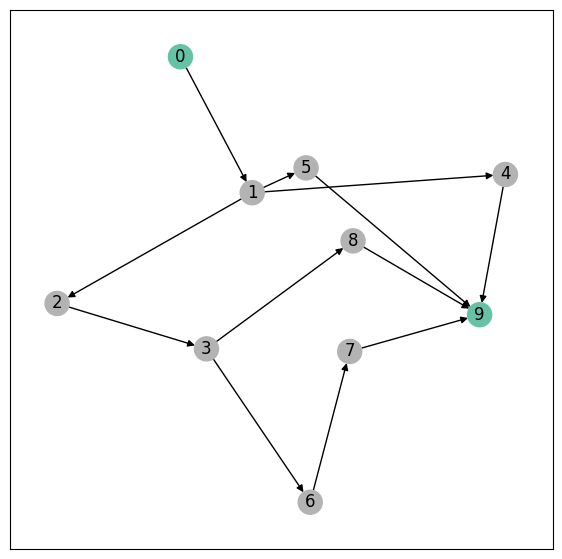

In [14]:
G = to_networkx(train_ds[1], to_undirected=False)
visualize_graph(G, color=dataset[0].x[..., 1] == 0);

In [15]:
loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [16]:
model = GNNProcessor(out_channels=1, 
                     num_edge_features=dataset.num_edge_features, 
                     latent_dim=64, 
                     num_convs=20, 
                     convs_hidden_layers=[64],
                     alpha_update_x=0.1,
                     aggr="mean",
                     device=device).to(device)

print(model)
print(next(model.parameters()).device)

GNNProcessor(
  (convs): ModuleList(
    (0-19): 20 x GNNSConv(aggr=mean, latent_dim=64, alpha=0.1, hidden_layers=[64])
  )
  (final): Linear(in_features=64, out_features=1, bias=True)
  (balance_conv): BalanceConv()
)
cuda:0


In [17]:
criterion = HydraulicsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [18]:
def train(pretrain_data=None):
  model.train()

  total_loss = 0
  for data in loader if pretrain_data is None else [pretrain_data]:
    data = data.to(device)
    optimizer.zero_grad()
    P, _, imbalance = model(data)
    loss = criterion(data, P, imbalance)    
    total_loss += loss.item() * data.num_graphs if pretrain_data is None else loss.item()
    loss.backward()
    optimizer.step()

  total_loss = total_loss / len(loader.dataset) if pretrain_data is None else total_loss
  return total_loss

In [19]:
# # pretrain the model
# for epoch in range(250):
#   loss = train(train_ds[0])
#   if (epoch % 10 == 0):
#     print(f'Pretraining epoch: {epoch:03d}, Loss: {loss:.4f}')   

In [20]:
# train
losses = []
for epoch in range(2000):
  loss = train()
  losses.append(loss)

  if (epoch % 10 == 0):
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') 

Epoch: 000, Loss: 13267.4801
Epoch: 010, Loss: 3654.7521
Epoch: 020, Loss: 982.0281
Epoch: 030, Loss: 943.9089
Epoch: 040, Loss: 1082.6641
Epoch: 050, Loss: 1638.2244
Epoch: 060, Loss: 823.2275
Epoch: 070, Loss: 762.7535
Epoch: 080, Loss: 803.1398
Epoch: 090, Loss: 1224.7865
Epoch: 100, Loss: 1042.8811
Epoch: 110, Loss: 1403.8153
Epoch: 120, Loss: 1443.6934
Epoch: 130, Loss: 893.7986
Epoch: 140, Loss: 962.2968
Epoch: 150, Loss: 786.7068
Epoch: 160, Loss: 709.1226
Epoch: 170, Loss: 906.5707
Epoch: 180, Loss: 1020.9075
Epoch: 190, Loss: 859.1652
Epoch: 200, Loss: 1056.7954
Epoch: 210, Loss: 874.4410
Epoch: 220, Loss: 1813.9578
Epoch: 230, Loss: 969.1023
Epoch: 240, Loss: 677.4038
Epoch: 250, Loss: 894.2847
Epoch: 260, Loss: 649.9832
Epoch: 270, Loss: 882.0144
Epoch: 280, Loss: 765.5917
Epoch: 290, Loss: 792.6922
Epoch: 300, Loss: 644.3217
Epoch: 310, Loss: 960.8445
Epoch: 320, Loss: 966.5352
Epoch: 330, Loss: 1036.2909
Epoch: 340, Loss: 1622.8296
Epoch: 350, Loss: 1007.2783
Epoch: 360, L

KeyboardInterrupt: 

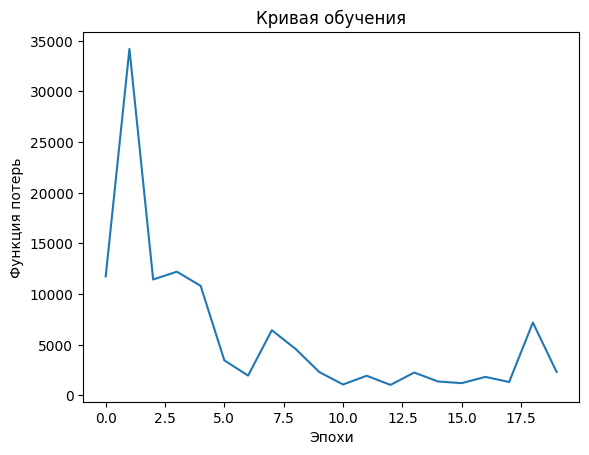

In [ ]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

# Тестирование модели

In [ ]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0], [0, 5.4]], dtype=torch.float32)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
%%timeit
# %%timeit 
# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# import torch_geometric
# compiled = torch_geometric.compile(model)